In [1]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.nn import functional as F
from torchvision import datasets, models, transforms
import torchvision.datasets.utils as dataset_utils

In [ ]:
# include plots in notebook
%matplotlib inline

In [3]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Wed Oct 26 23:10:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   34C    P0    50W / 350W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

In [5]:
def color_grayscale_arr(arr, red=True):
  """
  Convert grayscale MNIST images to either red or green MNIST images by expanding
  the image to three RGB dimensions. The grayscale image either gets applied to
  the red or green channel.
  """
  assert arr.ndim == 2
  
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)],axis=2)
  else:
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Downloads the grayscale MNIST dataset and transforms it into a colored MNIST dataset.
  Digits smaller than 5 are colored red for the train and validation set. Numbers larger
  than 5 are colored green for the train and validation set. The colors of the digits have
  a 50% probability to be flipped.
  """
  def __init__(self, root='./data', env='train', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train', 'val', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train, val and test')

  def __getitem__(self, index):
    """
    Overriden method from datasets.VisionDataset to apply transformations to the data
    before providing them to the dataloader.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    """
    Download 60'000 grayscale MNIST images, split them into a train, validation and a test
    dataset and transform them to a colored MNIST dataset.
    """
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'val.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train_set = []
    val_set = []
    test_set = []
    
    for idx, (im, label) in enumerate(train_mnist):
      im_array = np.array(im)
      
      # Assign the true binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # progress bar
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
        
      # train, validation and test splits
      if idx < 20000:
        phase = "train"
      elif idx < 40000:
        phase = "val"
      else:
        phase = "test"
        # Flip labels from test dataset with 50% probability
        if np.random.uniform() < 0.5:
          binary_label = binary_label ^ 1
        
      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0
      colored_arr = color_grayscale_arr(im_array, red=color_red)
      
      if phase == "train":
        train_set.append((Image.fromarray(colored_arr), binary_label))
      elif phase == "val":
        val_set.append((Image.fromarray(colored_arr), binary_label))
      else:
        test_set.append((Image.fromarray(colored_arr), binary_label))
        
    os.makedirs(colored_mnist_dir, exist_ok=True)
    torch.save(train_set, os.path.join(colored_mnist_dir, 'train.pt'))
    torch.save(val_set, os.path.join(colored_mnist_dir, 'val.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


In [6]:
def plot_digits(dataset):
    """
    Plots some digits from a provided colored MNIST dataset to be analyzed.
    """
    fig = plt.figure(figsize=(13,8))
    columns = 6
    rows = 3
    ax = []
    
    for i in range(columns*rows):
        img, label = dataset[i]
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("Label: " + str(label))
        plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

Colored MNIST dataset already exists


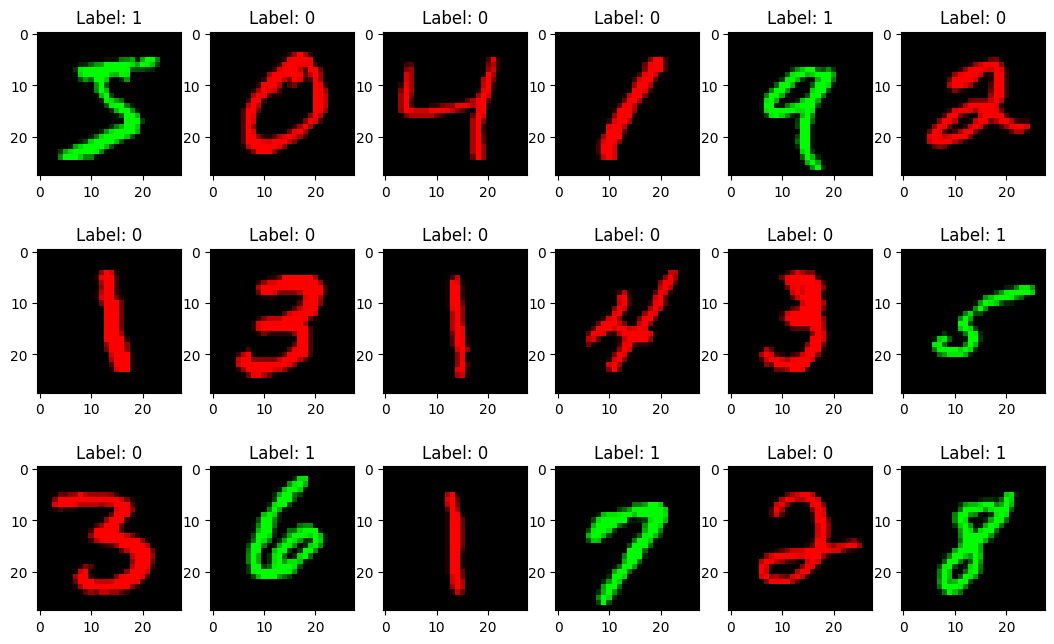

In [7]:
train_set = ColoredMNIST(root='./data',
                          env='train',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(train_set)

Colored MNIST dataset already exists


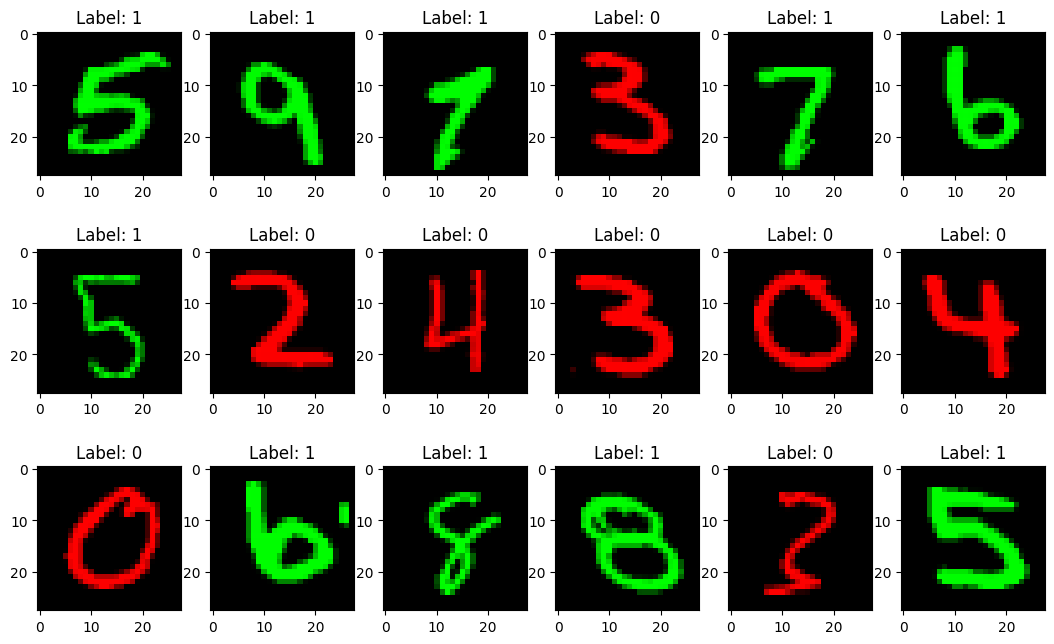

In [8]:
val_set = ColoredMNIST(root='./data',
                          env='val',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(val_set)

Colored MNIST dataset already exists


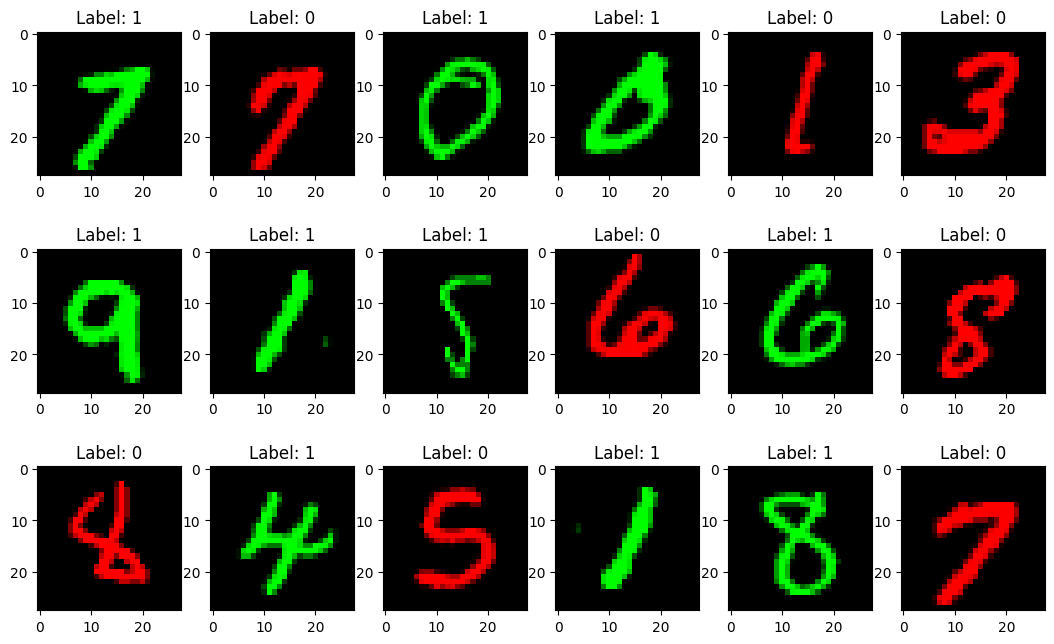

In [9]:
test_set = ColoredMNIST(root='./data',
                          env='test',
                          transform= transforms.Compose([transforms.ToTensor()]))
                            #   [transforms.ToTensor(),
                            #    transforms.Normalize(mean=(0.5,), std=(0.5,))]))
                            
plot_digits(test_set)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=10)

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=10)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=10)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 1)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0171,  0.0163,  0.0028,  ..., -0.0085, -0.0191,  0.0029]],
       device='cuda:0', requires_grad=True)

In [13]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train'          : {'loss' : [],
                                    'acc' : []},
                'validation'    : {'loss' : [],
                                    'acc' : []},
                'test'          : {'loss' : [],
                                    'acc' : []}}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation', 'test']:
            if phase == 'train':
                model.train()
                datasource = train_loader
            elif phase == "validation":
                model.eval()
                datasource = val_loader
            else:
                model.eval()
                datasource = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in datasource:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                
                labels = labels.unsqueeze(1)
                labels = labels.float()
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasource)
            epoch_acc = (running_corrects.double() / len(datasource)).item()

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
    return model, history

In [14]:
# criterion = F.binary_cross_entropy_with_logits
# optimizer = optim.Adam(model.fc.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# that's not possible ^^
# Epoch 1/10
# train loss: 0.0000, acc: 523.5200
# validation loss: 0.0000, acc: 521.0112

In [15]:
mdl, hist = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.9840
test loss: 0.0000, acc: 508.4160
Epoch 2/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.9840
test loss: 0.0000, acc: 508.4160
Epoch 3/3
----------
train loss: 0.0000, acc: 523.5200
validation loss: 0.0000, acc: 521.9840
test loss: 0.0000, acc: 508.4160


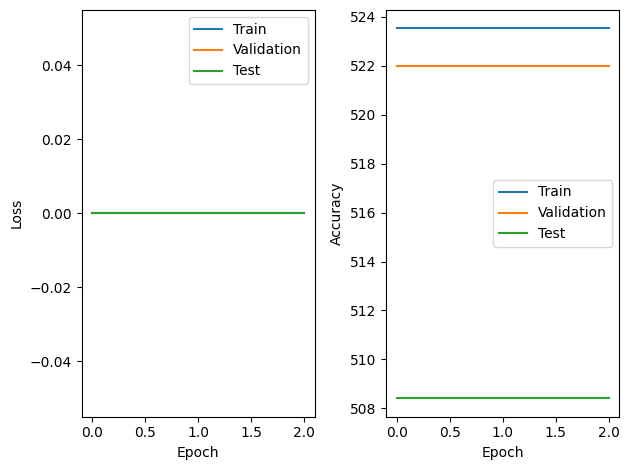

In [16]:
def plot_history(hist):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    plt.plot(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    plt.plot(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    plt.plot(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_history(hist)